In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scrublet as scr
import celltypist
from celltypist import models
import decoupler as dc
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=150)

# Import raw files

In [2]:
inpath="/home/lugli/spuccio/Projects/SP039/FileH5AD_input/"

In [3]:
UKF154 = sc.read(inpath+"UKF154.h5ad")
UKF185 = sc.read(inpath+"UKF185.h5ad")
UKF194 = sc.read(inpath+"UKF194.h5ad")
UKF294 = sc.read(inpath+"UKF294.h5ad")
UKF317 = sc.read(inpath+"UKF317.h5ad")
UKF322 = sc.read(inpath+"UKF322.h5ad")
UKF192 = sc.read(inpath+"UKF192.h5ad")
UKF234 = sc.read(inpath+"UKF234.h5ad")

# Read Metadata

In [4]:
metadata = pd.read_excel('Metadata2.xlsx')

In [5]:
metadata['Sample'] =   [ 'Patient' + str(col) for col in metadata.Sample]

# Fix Metadata 

In [6]:
def fixmeta(metadata,sample,adata):
    tmp1 = metadata.loc[metadata['SampleID'] == sample].loc[metadata.loc[metadata['SampleID'] == sample].index.repeat(adata.shape[0])]
    tmp1.reset_index(drop=True,inplace=True)
    tmp1.set_index( sample+"_"  + tmp1.index.astype(str),inplace=True) 
    adata.obs = tmp1
    return adata

In [7]:
UKF154 = fixmeta(metadata,"UKF154",UKF154)
UKF185 = fixmeta(metadata,"UKF185",UKF185)
UKF194 = fixmeta(metadata,"UKF194",UKF194)
UKF294 = fixmeta(metadata,"UKF294",UKF294)
UKF317 = fixmeta(metadata,"UKF317",UKF317)
UKF322 = fixmeta(metadata,"UKF322",UKF322)
UKF192 = fixmeta(metadata,"UKF192",UKF192)
UKF234 = fixmeta(metadata,"UKF234",UKF234)

# Concatenate 

In [8]:
UKF154.var_names_make_unique()
UKF185.var_names_make_unique()
UKF194.var_names_make_unique()
UKF294.var_names_make_unique()
UKF317.var_names_make_unique()
UKF322.var_names_make_unique()
UKF192.var_names_make_unique()
UKF234.var_names_make_unique()

In [9]:
adata = UKF154.concatenate(UKF185,UKF194,UKF294,UKF317,UKF322,UKF192,UKF234,
                         index_unique=None)

In [10]:
del(UKF154,UKF185,UKF194,UKF294,UKF317,UKF322,UKF192,UKF234)

In [11]:
print(adata.obs['SampleID'].value_counts())
adata

UKF317    10777
UKF294     6725
UKF234     5720
UKF194     5647
UKF322     5387
UKF185     4237
UKF154     3759
UKF192     3363
Name: SampleID, dtype: int64


AnnData object with n_obs × n_vars = 45615 × 26615
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch'

In [12]:
adata.layers['raw'] = adata.X 

# Calculate QC

In [13]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

In [14]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [15]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [16]:
adata

AnnData object with n_obs × n_vars = 45615 × 26615
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw'

# Plot QC

... storing 'SampleID' as categorical
... storing 'GEO_RNA' as categorical
... storing 'Cohort' as categorical
... storing 'Type' as categorical
... storing 'Subtype' as categorical
... storing 'Diagnosis' as categorical
... storing 'Grade' as categorical
... storing 'Location' as categorical
... storing 'IDH1_Status' as categorical
... storing 'EGFR_Status' as categorical
... storing 'MGMT' as categorical
... storing 'Sample' as categorical
... storing 'Sex' as categorical
... storing 'Age' as categorical
... storing 'Sorted' as categorical
... storing 'MET' as categorical


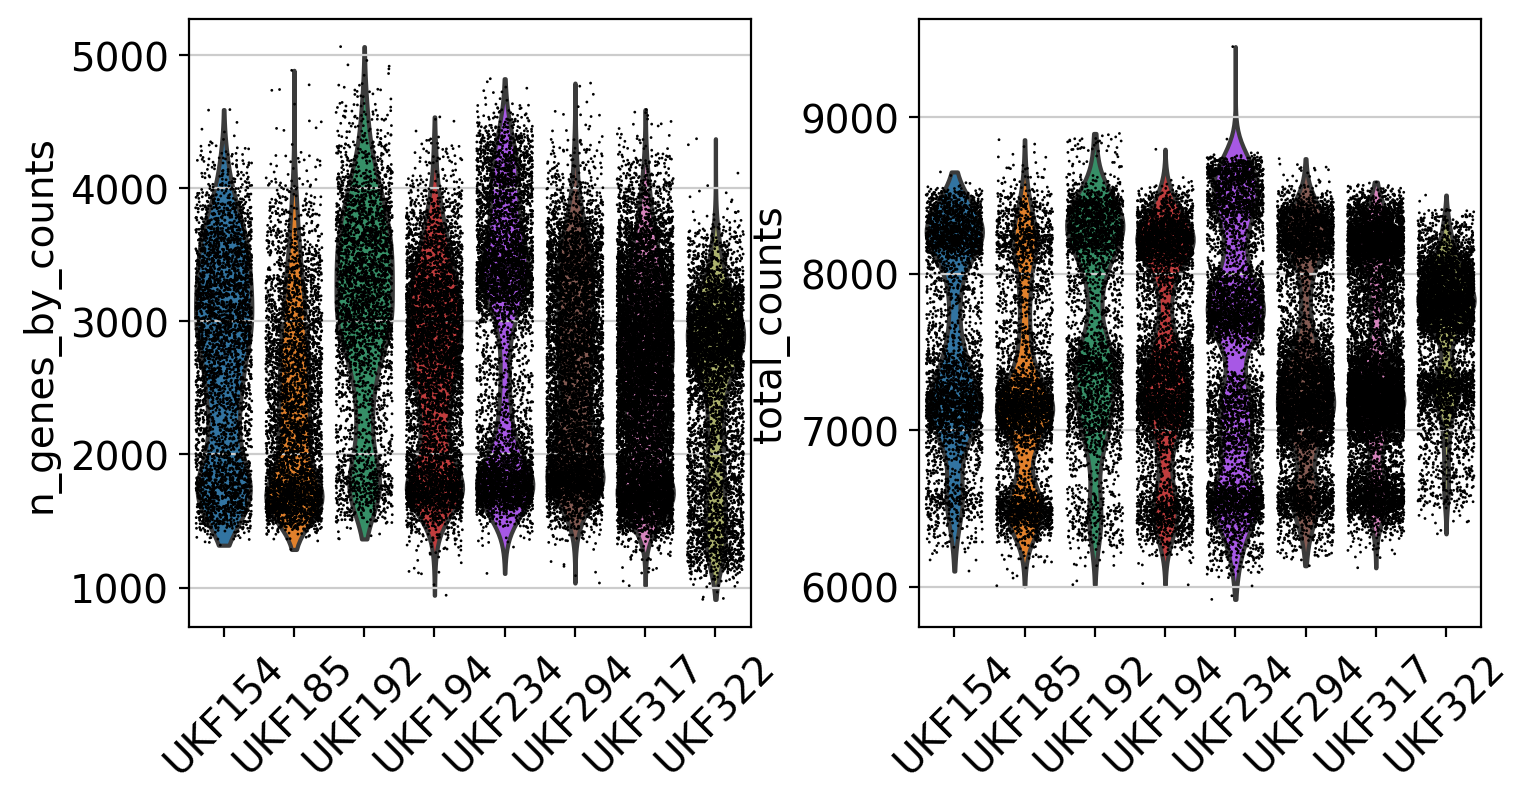

In [17]:
sc.set_figure_params(dpi=100)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

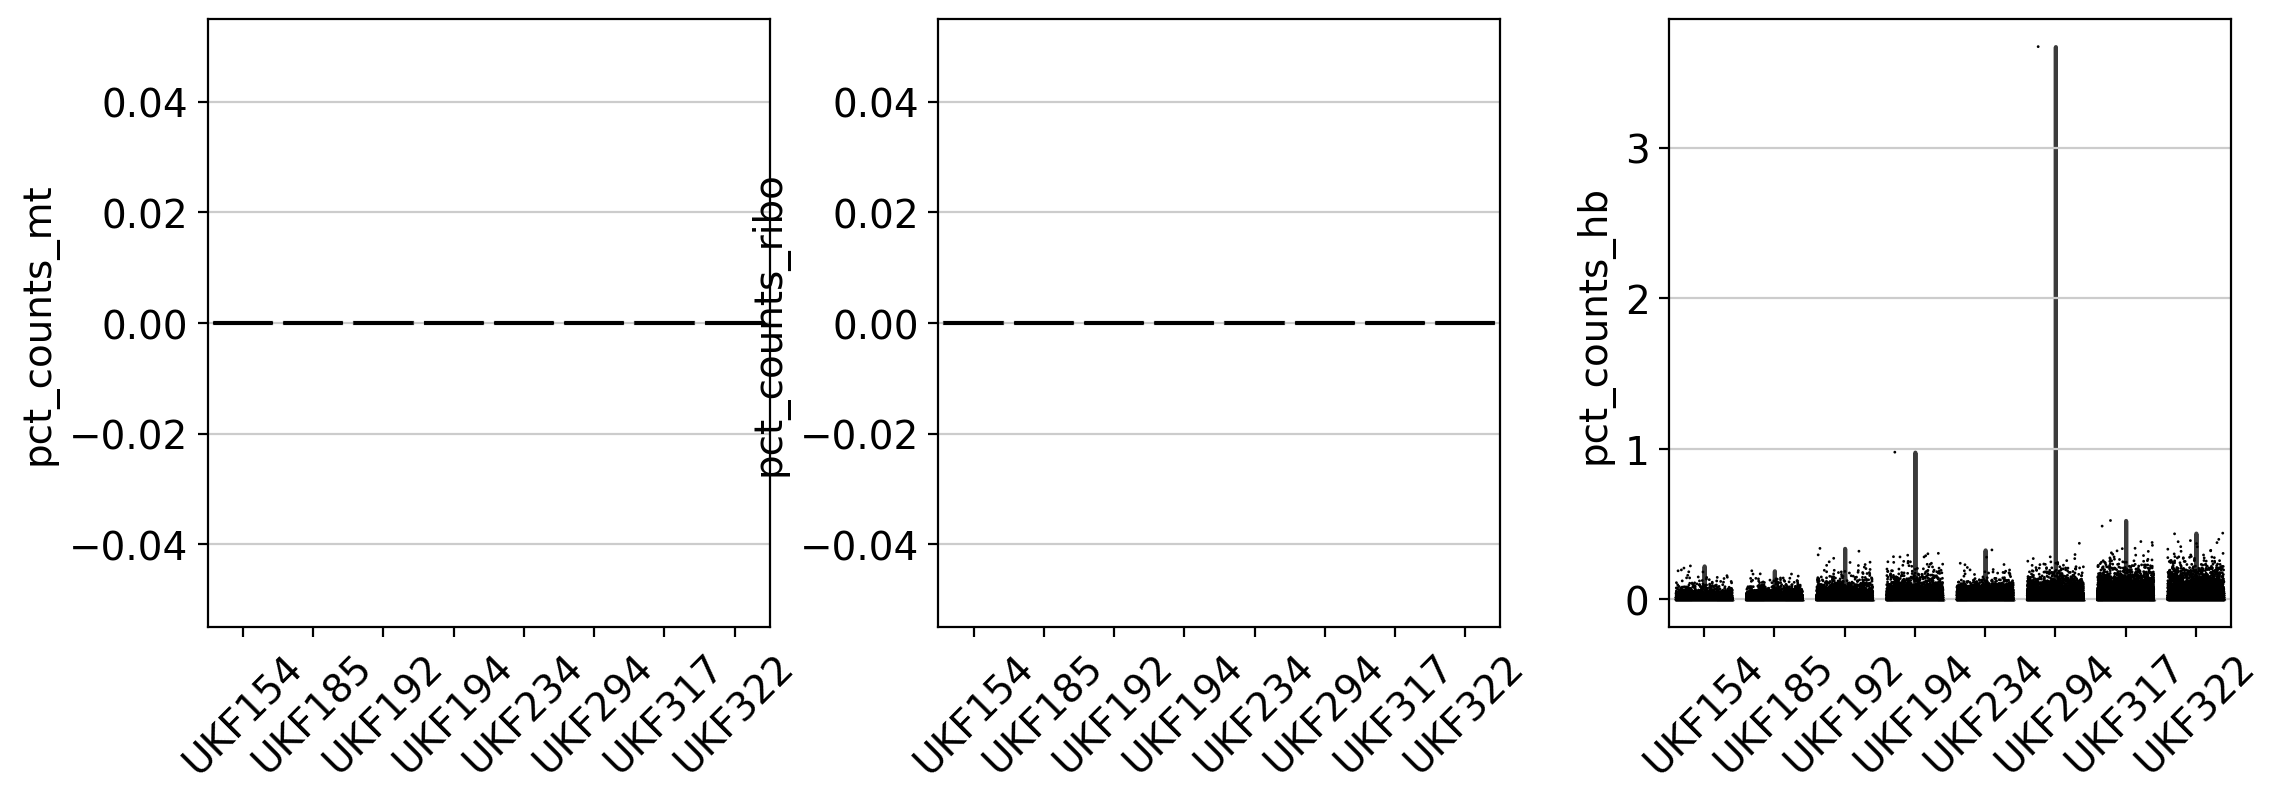

In [18]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

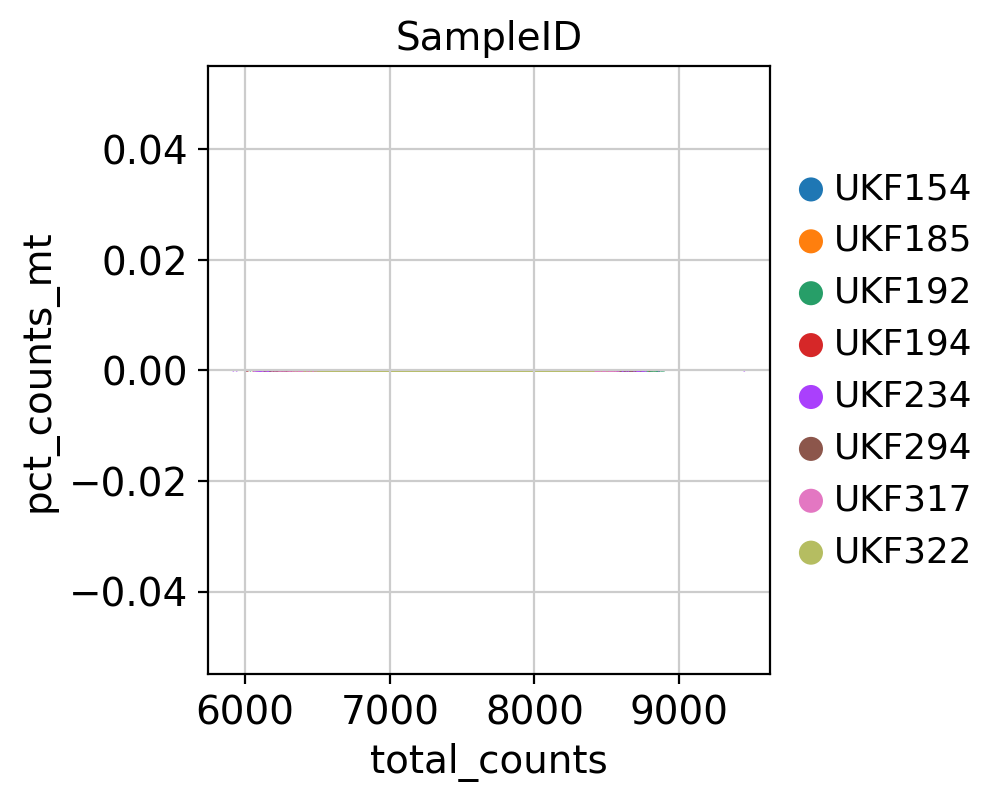

In [19]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="SampleID")

# Filtering

In [20]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

45615 26462


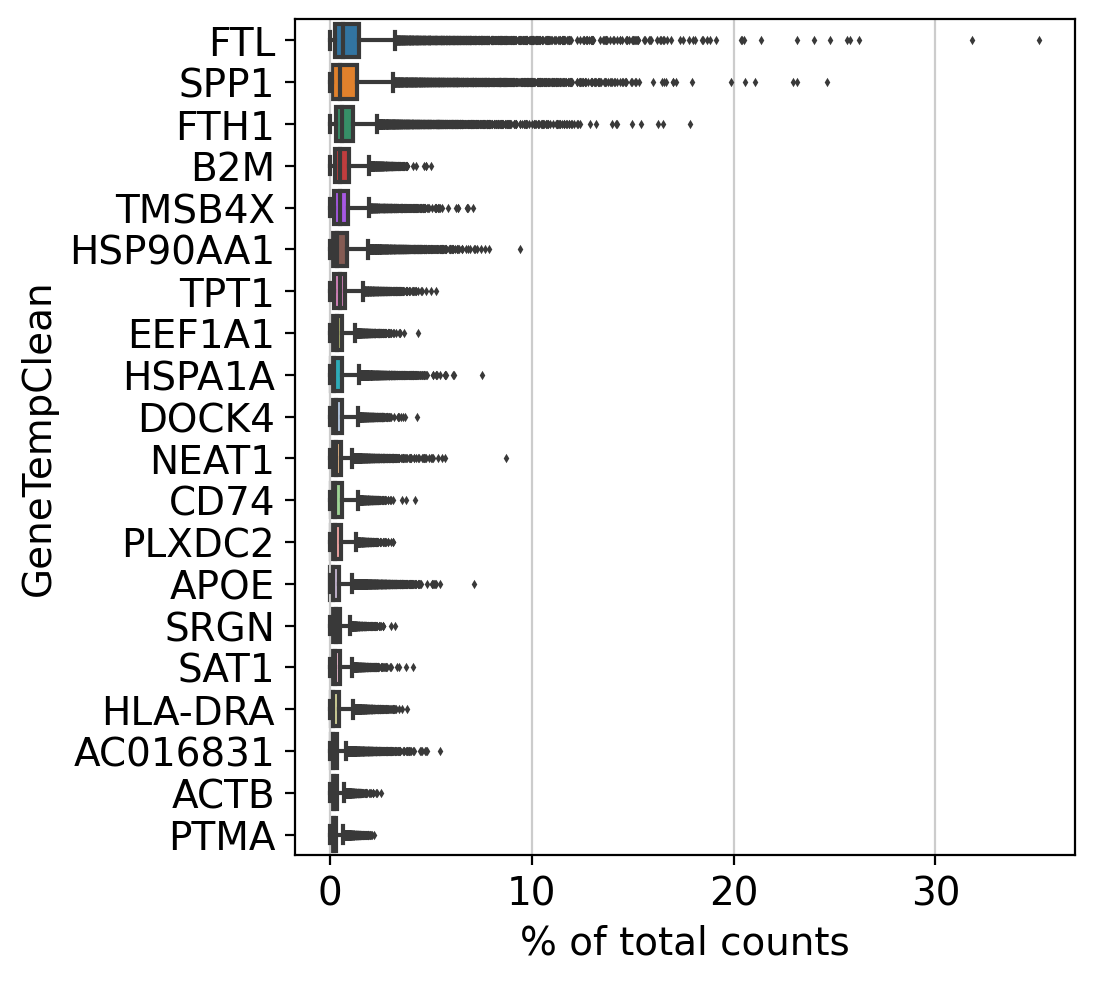

In [21]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Mito/Ribo filtering

In [22]:
#adata = adata[adata.obs['pct_counts_mt'] < 20, :]

# filter for percent ribo > 0.05
#adata = adata[adata.obs['pct_counts_ribo'] > 5, :]
adata = adata[adata.obs['pct_counts_hb'] < 2, :]
print("Remaining cells %d"%adata.n_obs)

Remaining cells 45614


# Plot filtered QC

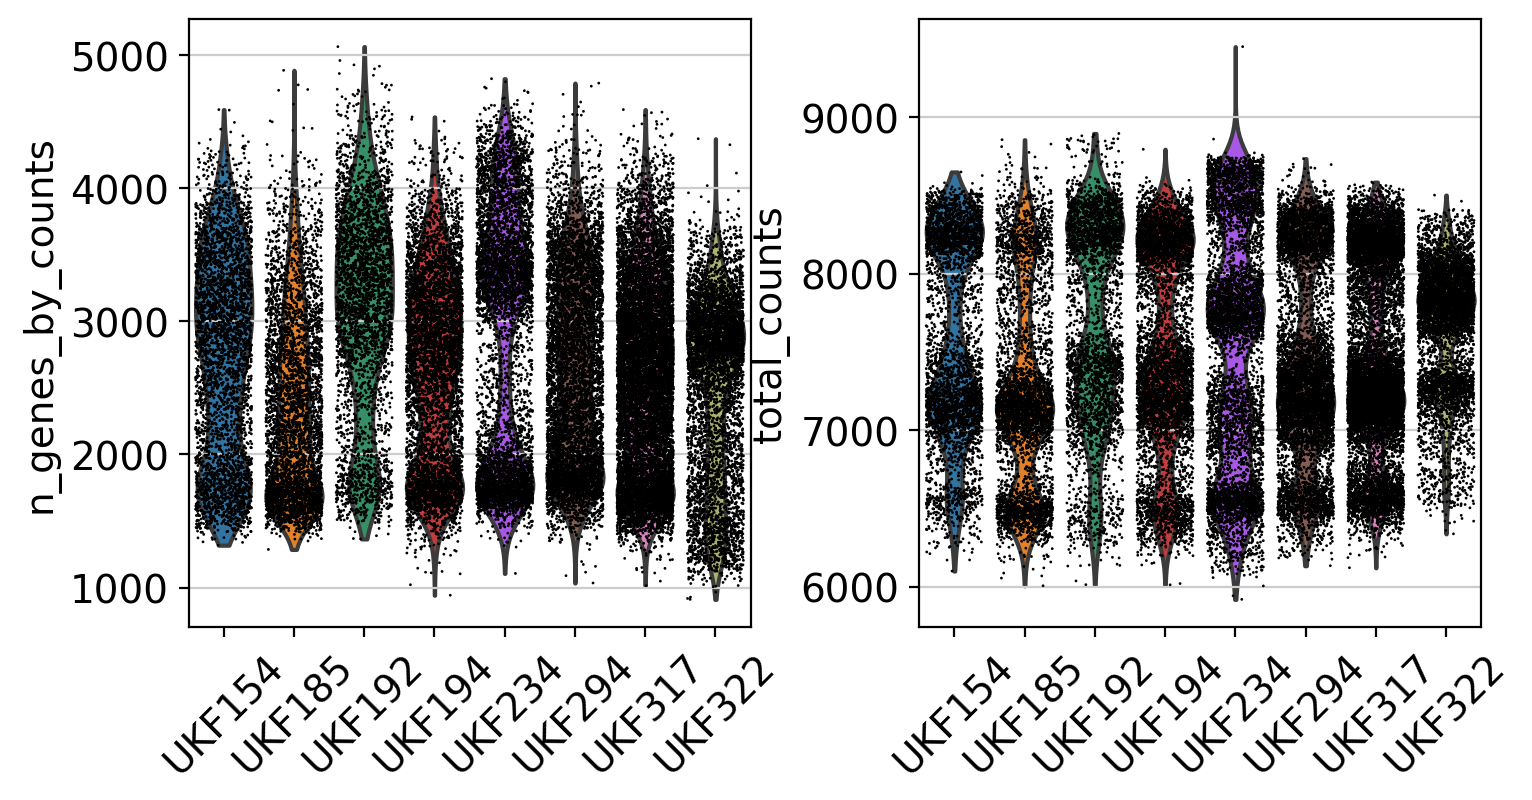

In [23]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

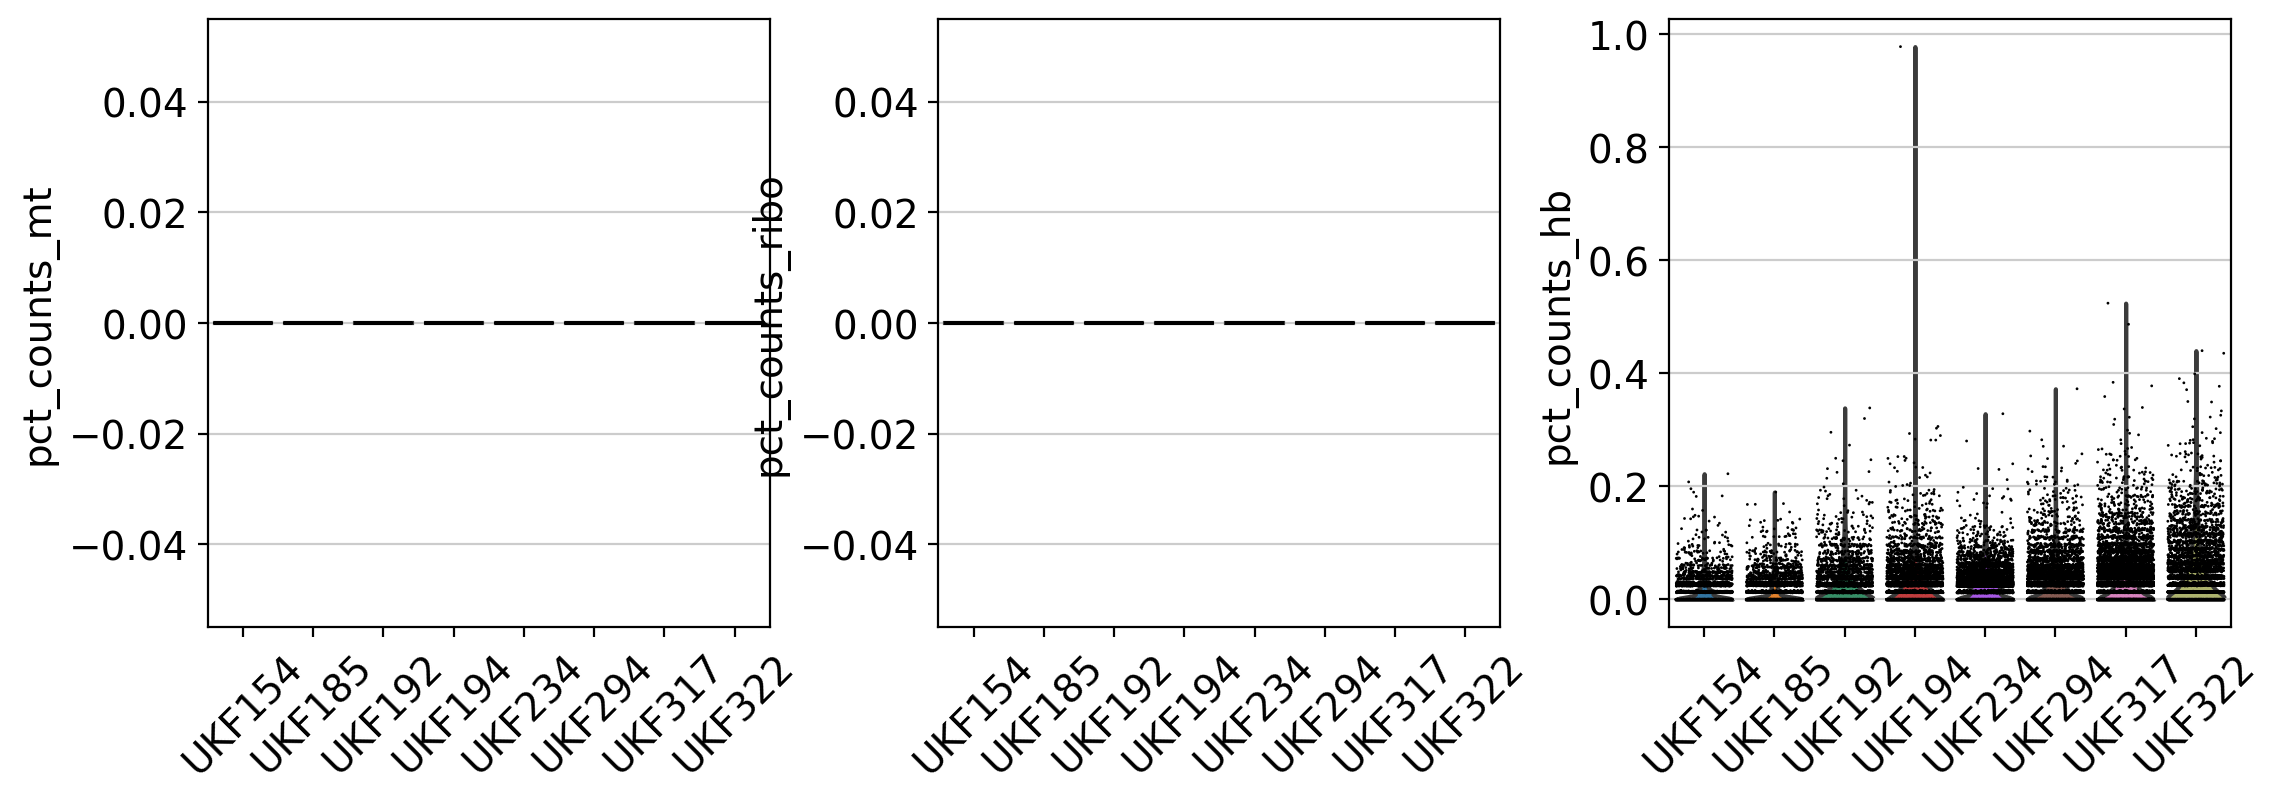

In [24]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

# Filter genes

In [25]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")

In [26]:
mito_gene_indicator = np.in1d(adata.var_names, mito_gene_names)

In [27]:
adata = adata[:, ~mito_gene_indicator]

In [28]:
print(adata.n_obs, adata.n_vars)
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
ribo_genes = adata.var_names.str.startswith(("RPL","RPS"))
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(ribo_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

45614 26462
45614 26455


# Calculate cell-cycle scores

In [29]:
cell_cycle_genes = [x.strip() for x in open('/home/lugli/spuccio/Projects/SP035_TregIntegration/Analysis/regev_lab_cell_cycle_genes_homo.txt')]
print(len(cell_cycle_genes))
# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

90
90


In [30]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


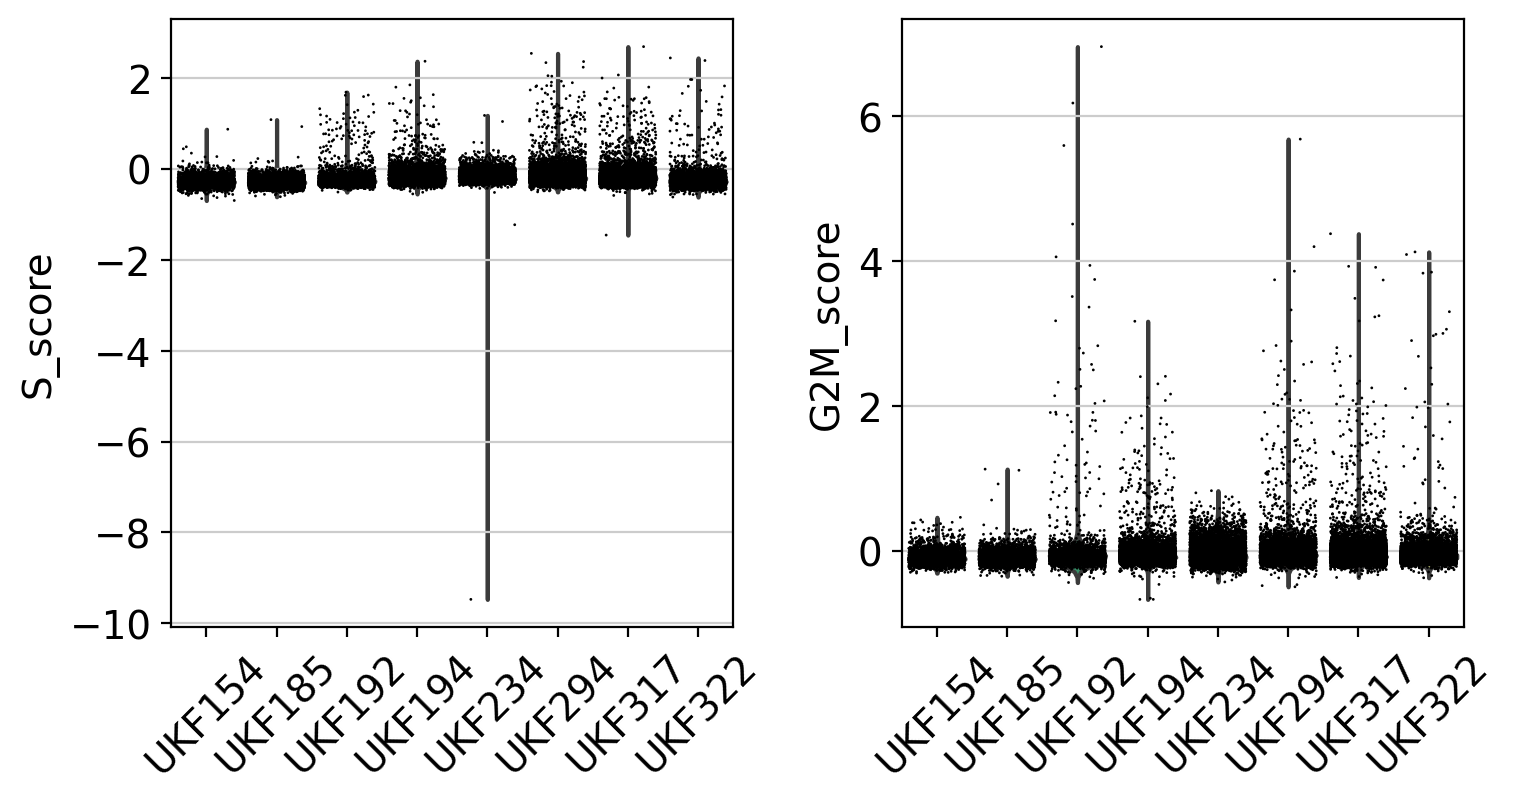

In [31]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'SampleID', rotation=45)

# Predict doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 41.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.9%
Elapsed time: 77.1 seconds


178

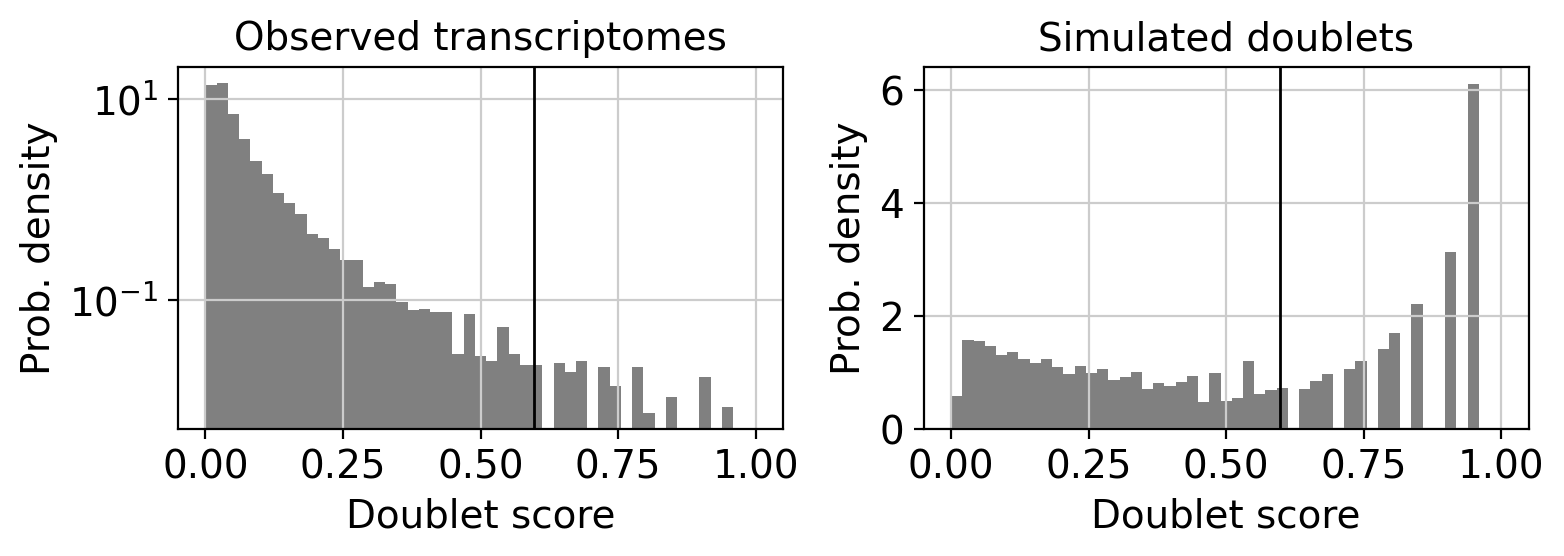

In [32]:
scrub = scr.Scrublet(adata.layers['raw'])
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [33]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical


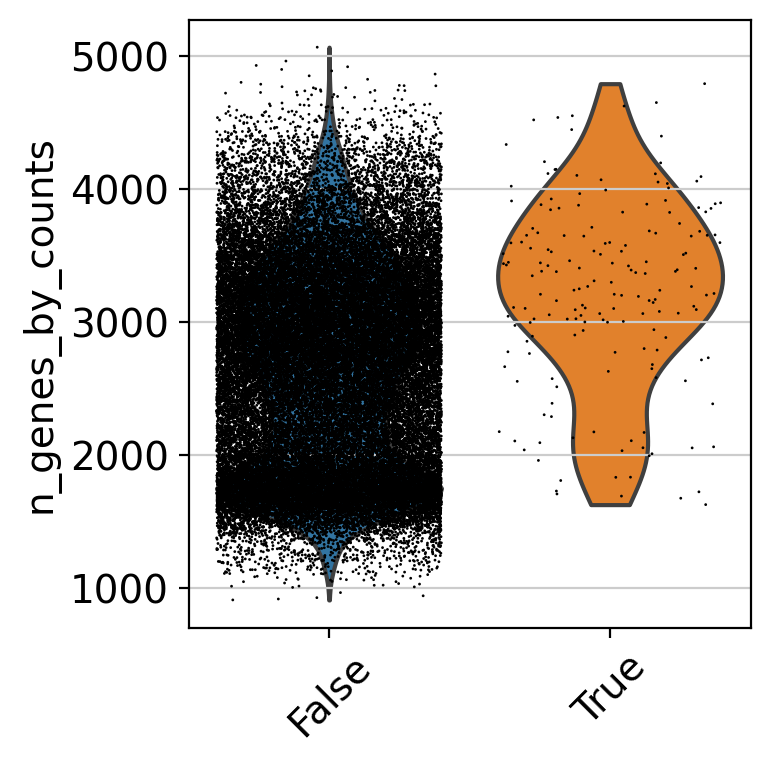

In [34]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'doublet_info', rotation=45)

In [35]:
adata = adata[adata.obs['doublet_info'] == "False",:]

# Processing 

In [36]:
#adata = adata[adata.obs.n_genes_by_counts < 3000, :]
# save normalized counts in raw slot.
adata.raw = adata
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata.layers['cpm'] = adata.X
# logaritmize
sc.pp.log1p(adata)
adata.layers['log1p'] = adata.X
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# Filter higly variable genes
#adata.raw = adata

# scale
#sc.pp.scale(adata)

# Celltypist classification

In [37]:
sc.tl.pca(adata,svd_solver='arpack',copy=False)

In [38]:
sc.pp.neighbors(adata,n_neighbors=10, n_pcs=40)

In [39]:
sce.pp.harmony_integrate(adata, ['SampleID'])

2022-06-14 15:12:35,661 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2022-06-14 15:12:44,850 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2022-06-14 15:12:54,023 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2022-06-14 15:13:03,195 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2022-06-14 15:13:12,354 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2022-06-14 15:13:21,525 - harmonypy - INFO - Converged after 5 iterations
Converged after 5 iterations


In [40]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca_harmony')

In [41]:
sc.tl.umap(adata)

In [42]:
adata.obsm['X_umap_harmony'] = adata.obsm['X_umap']

In [43]:
adata

AnnData object with n_obs × n_vars = 45436 × 26455
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'raw', 'cpm', 'log1p'
    obsp: 'distances', 'connectivities'

In [44]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 13
📂 Storing models in /home/lugli/spuccio/.celltypist/data/models
💾 Downloading model [1/13]: Immune_All_Low.pkl
💾 Downloading model [2/13]: Immune_All_High.pkl
💾 Downloading model [3/13]: Immune_All_PIP.pkl
💾 Downloading model [4/13]: Immune_All_AddPIP.pkl
💾 Downloading model [5/13]: COVID19_Immune_Landscape.pkl
💾 Downloading model [6/13]: Cells_Fetal_Lung.pkl
💾 Downloading model [7/13]: Cells_Intestinal_Tract.pkl
💾 Downloading model [8/13]: Cells_Lung_Airway.pkl
💾 Downloading model [9/13]: Developing_Mouse_Brain.pkl
💾 Downloading model [10/13]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [11/13]: Human_Lung_Atlas.pkl
💾 Downloading model [12/13]: Nuclei_Lung_Airway.pkl
💾 Downloading model [13/13]: Pan_Fetal_Human.pkl


In [45]:
model = models.Model.load(model = 'Immune_All_High.pkl')

In [46]:
predictionsHigh = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True)

🔬 Input data has 45436 cells and 26455 genes
🔗 Matching reference genes in the model
🧬 2804 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


In [47]:
#adata.obs['CellCount']= adata.obs['CellCount'].astype(int)

In [48]:
adata.obs['Sample'].value_counts()

Patient67    10740
Patient66     6689
Patient70     5691
Patient65     5632
Patient68     5360
Patient64     4220
Patient63     3750
Patient69     3354
Name: Sample, dtype: int64

In [49]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_L_PMID35177622.h5ad")

In [50]:
predictionsHigh.to_adata()

AnnData object with n_obs × n_vars = 45436 × 26455
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'raw', 'cpm', 'log1p'
    obsp: 

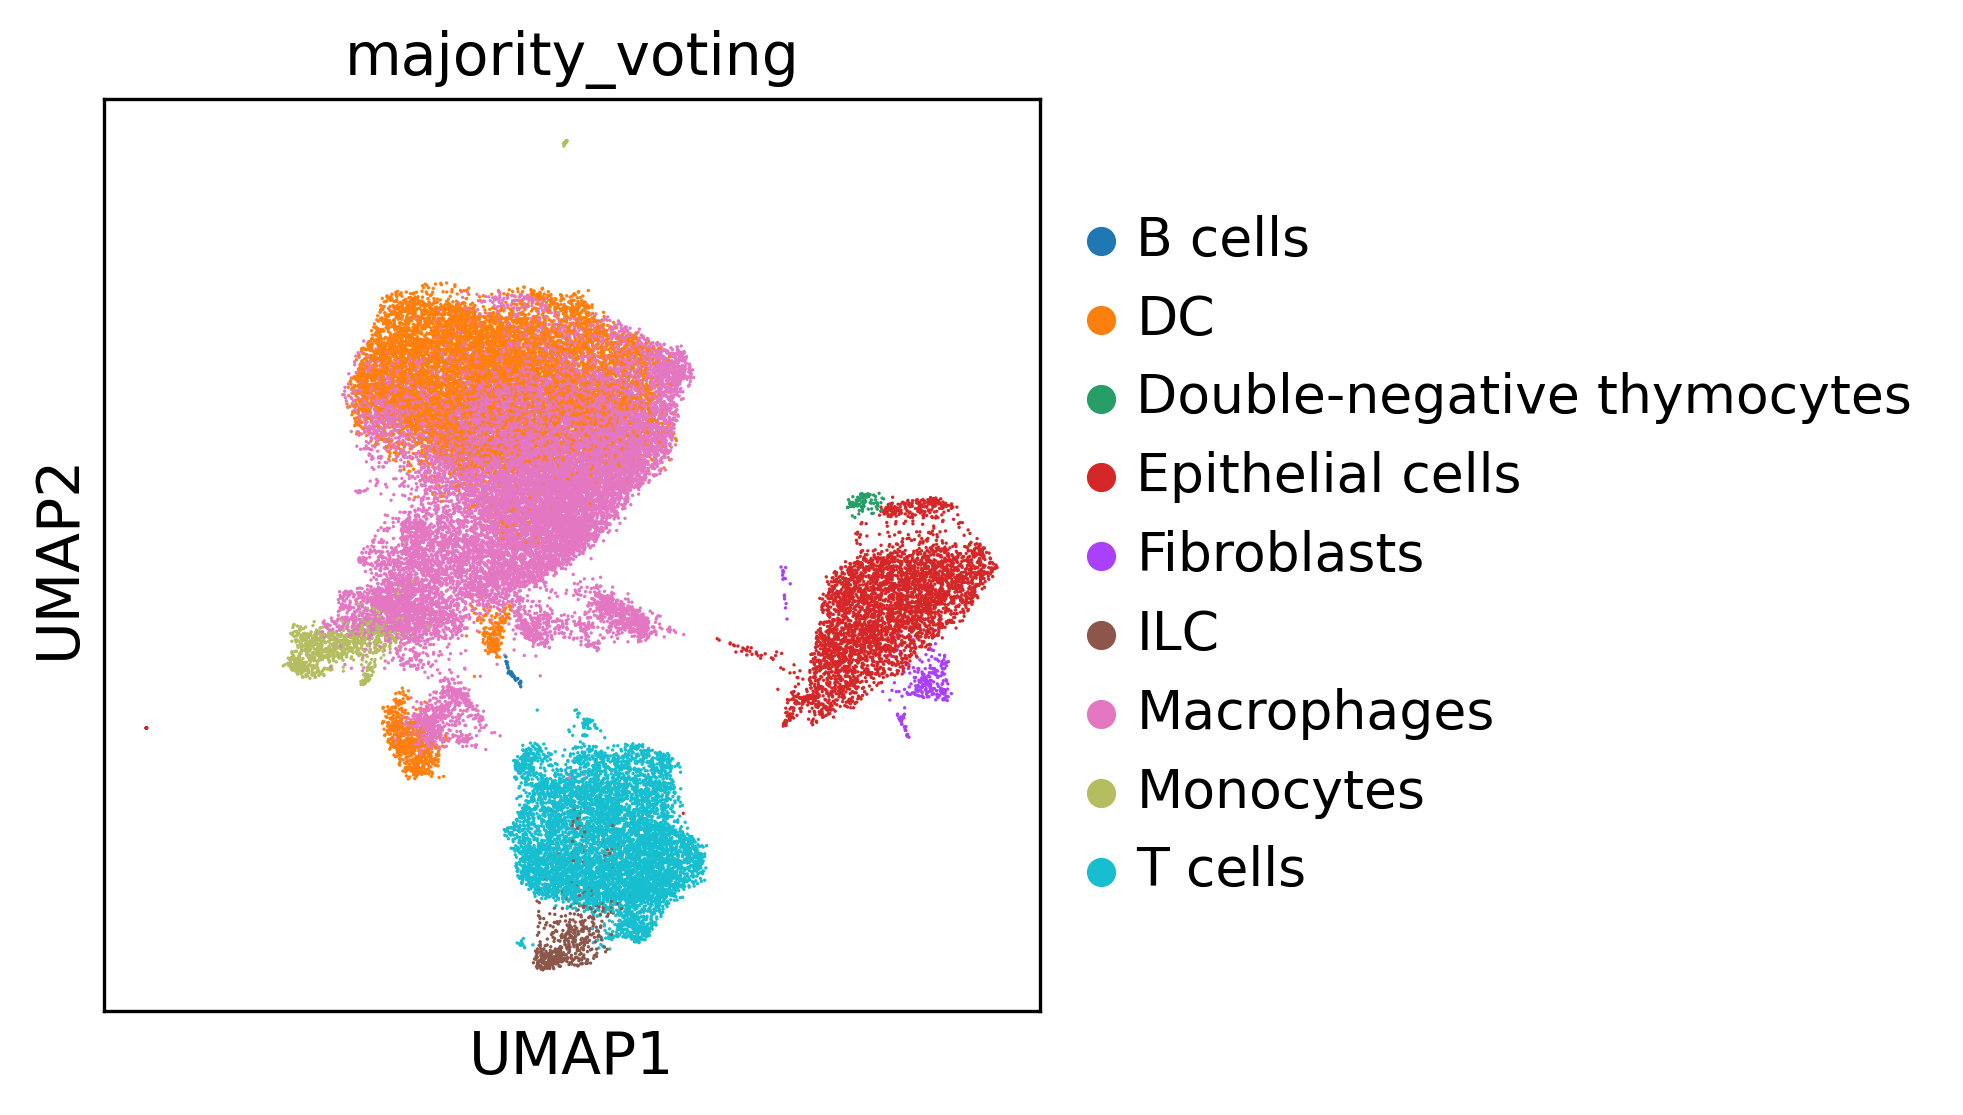

In [51]:
sc.set_figure_params(dpi=150)
sc.pl.umap(predictionsHigh.to_adata(), color='majority_voting')

# PanglaoDB classification

In [52]:
adata = adata[:, adata.var.highly_variable]

In [53]:
markers = dc.get_resource('PanglaoDB')
markers

label genesymbol canonical_marker         cell_type germ_layer human  \
0          CTRB1            False       Enterocytes   Endoderm  True   
1          CTRB1             True      Acinar cells   Endoderm  True   
2           KLK1             True      Acinar cells   Endoderm  True   
3           KLK1            False      Goblet cells   Endoderm  True   
4           KLK1            False  Epithelial cells   Mesoderm  True   
...          ...              ...               ...        ...   ...   
8472     SLC14A1             True  Urothelial cells   Mesoderm  True   
8473       UPK3A             True  Urothelial cells   Mesoderm  True   
8474       UPK1A             True  Urothelial cells   Mesoderm  True   
8475        UPK2             True  Urothelial cells   Mesoderm  True   
8476       UPK3B             True  Urothelial cells   Mesoderm  True   

label human_sensitivity human_specificity mouse mouse_sensitivity  \
0                   0.0        0.00439422  True        0.00331126   
1                   1.0       0.000628931  True          0.957143   
2              0.833333        0.00503145  True          0.314286   
3              0.588235        0.00503937  True          0.903226   
4                   0.0        0.00823306  True          0.225806   
...                 ...               ...   ...               ...   
8472                0.0         0.0181704  True               0.0   
8473                0.0               0.0  True               0.0   
8474                0.0               0.0  True               0.0   
8475                0.0               0.0  True               0.0   
8476                0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
0             0.0204803        9606         GI tract           0.017  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
3             0.0124084        9606         GI tract           0.013  
4             0.0137585        9606       Epithelium           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[8477 rows x 13 columns]

In [54]:
markers['organ'].value_counts()

Immune system         1775
Brain                 1589
GI tract               540
Kidney                 450
Reproductive           429
Connective tissue      413
Vasculature            372
Pancreas               365
Liver                  310
Epithelium             258
Blood                  247
Bone                   215
Lungs                  210
Skin                   172
Skeletal muscle        168
Olfactory system       136
Heart                  131
Smooth muscle          130
Eye                    122
Mammary gland           94
Zygote                  85
Embryo                  56
Placenta                28
Thymus                  27
Adrenal glands          25
Oral cavity             18
Thyroid                 14
Urinary bladder         11
Parathyroid glands      10
Name: organ, dtype: int64

In [55]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

label genesymbol canonical_marker                     cell_type germ_layer  \
1          CTRB1             True                  Acinar cells   Endoderm   
2           KLK1             True                  Acinar cells   Endoderm   
5           KLK1             True               Principal cells   Mesoderm   
7           KLK1             True  Plasmacytoid dendritic cells   Mesoderm   
8           KLK1             True             Endothelial cells   Mesoderm   
...          ...              ...                           ...        ...   
8472     SLC14A1             True              Urothelial cells   Mesoderm   
8473       UPK3A             True              Urothelial cells   Mesoderm   
8474       UPK1A             True              Urothelial cells   Mesoderm   
8475        UPK2             True              Urothelial cells   Mesoderm   
8476       UPK3B             True              Urothelial cells   Mesoderm   

label human human_sensitivity human_specificity mouse mouse_sensitivity  \
1      True               1.0       0.000628931  True          0.957143   
2      True          0.833333        0.00503145  True          0.314286   
5      True               0.0        0.00814536  True          0.285714   
7      True               0.0        0.00820189  True               1.0   
8      True               0.0        0.00841969  True               0.0   
...     ...               ...               ...   ...               ...   
8472   True               0.0         0.0181704  True               0.0   
8473   True               0.0               0.0  True               0.0   
8474   True               0.0               0.0  True               0.0   
8475   True               0.0               0.0  True               0.0   
8476   True               0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
5             0.0140583        9606           Kidney           0.013  
7             0.0129136        9606    Immune system           0.013  
8             0.0149153        9606      Vasculature           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[5180 rows x 13 columns]

In [56]:
# Run leiden clustering algorithm
sc.tl.leiden(adata)

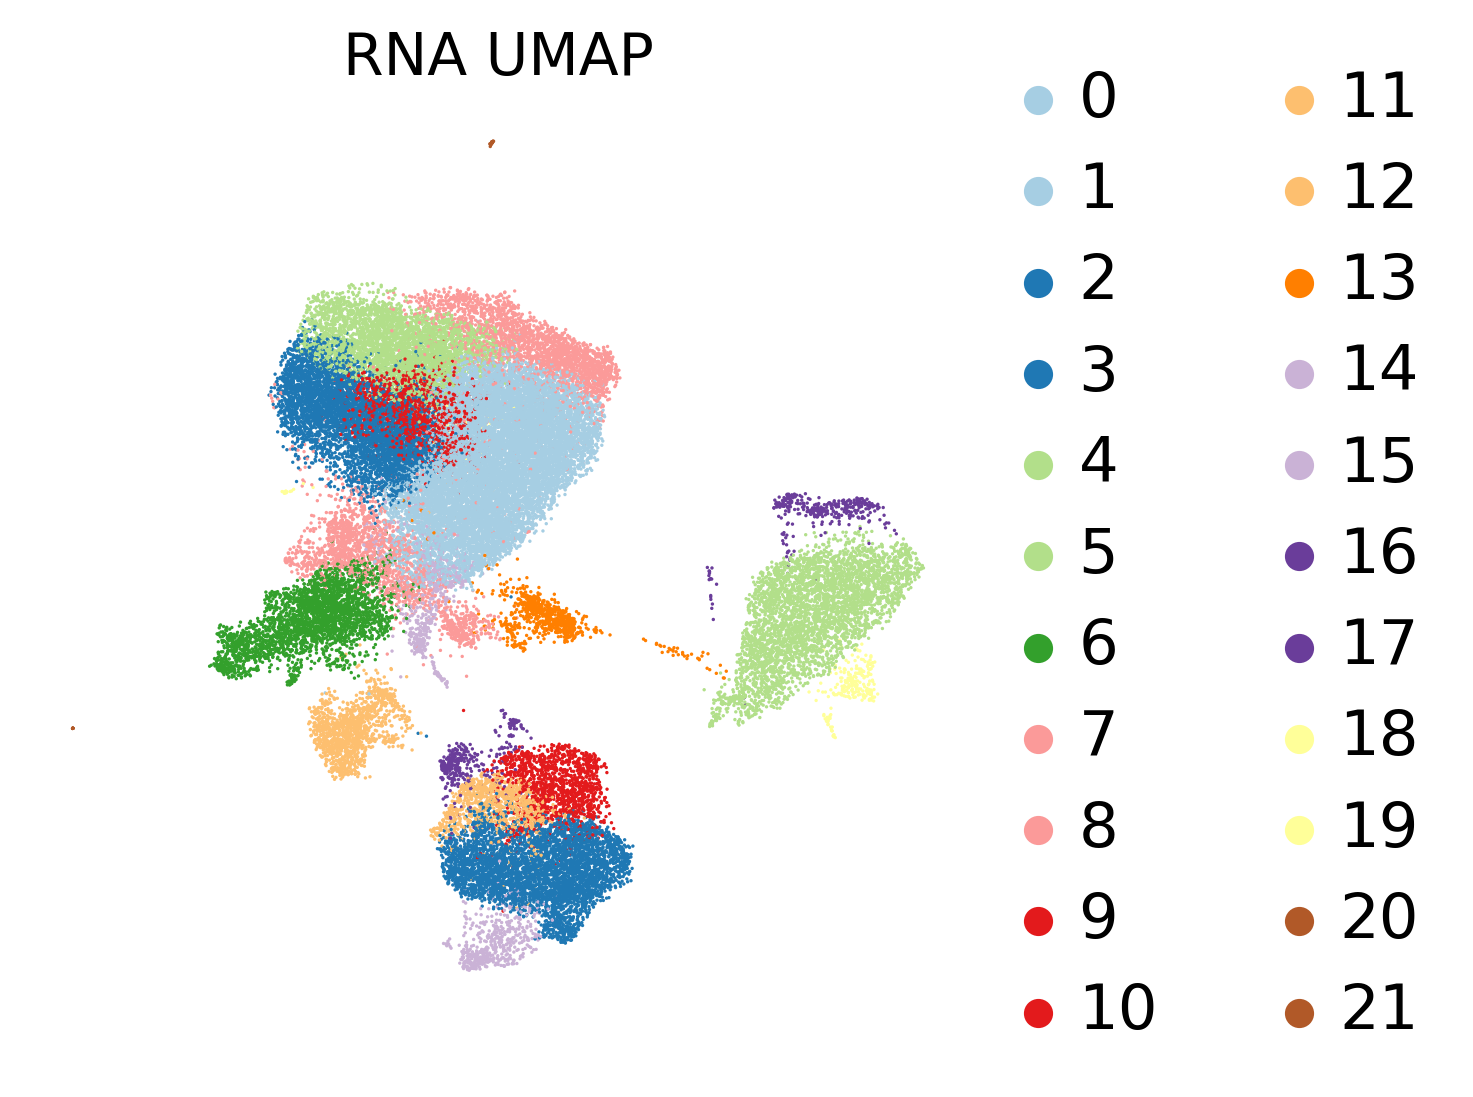

In [57]:
# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',palette='Paired',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [58]:
dc.run_ora(mat=adata, net=markers, source='cell_type', target='genesymbol', min_n=3, verbose=True,use_raw=False)

Running ora on mat with 45436 samples and 3669 targets for 110 sources.


100%|██████████| 45436/45436 [00:17<00:00, 2641.97it/s]


In [59]:
adata.obsm['ora_estimate']

source       Acinar cells  Adipocytes  Alpha cells  Alveolar macrophages  \
UKF154_0        -0.000000    2.818750    -0.000000                  -0.0   
UKF154_1        -0.000000    2.818750    -0.000000                  -0.0   
UKF154_2         1.097818    1.657946    -0.000000                  -0.0   
UKF154_3        -0.000000    0.685243     2.765746                  -0.0   
UKF154_4        -0.000000    2.818750     1.203019                  -0.0   
...                   ...         ...          ...                   ...   
UKF234_5715     -0.000000   -0.000000    -0.000000                  -0.0   
UKF234_5716     -0.000000   -0.000000    -0.000000                  -0.0   
UKF234_5717     -0.000000   -0.000000    -0.000000                  -0.0   
UKF234_5718     -0.000000    0.685243    -0.000000                  -0.0   
UKF234_5719      1.097818   -0.000000    -0.000000                  -0.0   

source       Astrocytes   B cells  B cells memory  B cells naive  Basophils  \
UKF154_0       1.763649 -0.000000        2.720212       1.625782   4.435154   
UKF154_1       1.763649  1.886441        0.655656      -0.000000   0.753255   
UKF154_2       0.734984  0.792849        0.655656       0.670130   0.753255   
UKF154_3       0.734984 -0.000000        1.594954      -0.000000   0.753255   
UKF154_4       1.763649  0.792849        0.655656       0.670130   3.044891   
...                 ...       ...             ...            ...        ...   
UKF234_5715    0.734984  4.617583       10.074521      10.223722   1.802436   
UKF234_5716    0.734984 -0.000000       -0.000000       0.670130  -0.000000   
UKF234_5717    1.763649 -0.000000       -0.000000      -0.000000  -0.000000   
UKF234_5718    0.734984  0.792849       -0.000000       1.625782   1.802436   
UKF234_5719    1.763649 -0.000000        0.655656      -0.000000  -0.000000   

source       Bergmann glia  ...  Sebocytes  Sertoli cells  \
UKF154_0          0.887730  ...  -0.000000      -0.000000   
UKF154_1          0.887730  ...  -0.000000       0.978773   
UKF154_2          0.887730  ...  -0.000000       0.978773   
UKF154_3          0.887730  ...  -0.000000       2.281569   
UKF154_4          2.087788  ...   1.267989       2.281569   
...                    ...  ...        ...            ...   
UKF234_5715       0.887730  ...  -0.000000      -0.000000   
UKF234_5716       0.887730  ...  -0.000000       5.489453   
UKF234_5717       0.887730  ...  -0.000000       2.281569   
UKF234_5718       0.887730  ...  -0.000000      -0.000000   
UKF234_5719       0.887730  ...  -0.000000       3.799841   

source       Smooth muscle cells   T cells  T helper cells  \
UKF154_0               -0.000000  1.281734        0.978773   
UKF154_1                0.792849  0.509604        2.281569   
UKF154_2               -0.000000  0.509604        0.978773   
UKF154_3               -0.000000  0.509604       -0.000000   
UKF154_4                0.792849 -0.000000       -0.000000   
...                          ...       ...             ...   
UKF234_5715            -0.000000  1.281734        0.978773   
UKF234_5716            -0.000000 -0.000000       -0.000000   
UKF234_5717             1.886441 -0.000000        0.978773   
UKF234_5718             1.886441 -0.000000        0.978773   
UKF234_5719             1.886441 -0.000000       -0.000000   

source       T regulatory cells  Tanycytes  Taste receptor cells  Thymocytes  \
UKF154_0                   -0.0  -0.000000                  -0.0    0.945970   
UKF154_1                   -0.0  -0.000000                  -0.0    0.945970   
UKF154_2                   -0.0  -0.000000                  -0.0    3.688845   
UKF154_3                   -0.0  -0.000000                  -0.0    0.945970   
UKF154_4                   -0.0  -0.000000                  -0.0   -0.000000   
...                         ...        ...                   ...         ...   
UKF234_5715                -0.0  -0.000000                  -0.0    2.211642   
UKF234_5716         

In [60]:
adata.obsm['ora_estimate'].columns

Index(['Acinar cells', 'Adipocytes', 'Alpha cells', 'Alveolar macrophages',
       'Astrocytes', 'B cells', 'B cells memory', 'B cells naive', 'Basophils',
       'Bergmann glia',
       ...
       'Sebocytes', 'Sertoli cells', 'Smooth muscle cells', 'T cells',
       'T helper cells', 'T regulatory cells', 'Tanycytes',
       'Taste receptor cells', 'Thymocytes', 'Tuft cells'],
      dtype='object', name='source', length=110)

In [61]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts

AnnData object with n_obs × n_vars = 45436 × 110
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony', 'ora_estimate', 'ora_pvals'

In [62]:
mean_enr = dc.summarize_acts(acts, groupby='leiden', min_std=1)
mean_enr

Bergmann glia  Chondrocytes  Dendritic cells  Enterocytes  Eosinophils  \
0        1.485386      1.379440         6.285216     2.030877     2.528643   
1        2.049707      2.303807         9.971669     2.547912     2.610745   
10       0.960902      0.998691         3.545168     0.477584     1.997483   
11       1.621871      1.519951         6.962801     1.477081     2.787709   
12       0.809929      1.282105         3.550241     0.402652     2.031859   
13       2.333226      1.964938         9.189584     2.380335     3.008976   
14       1.564680      1.844900        11.163198     1.474493     1.581367   
15       1.222507      1.359810         2.595896     0.345057     2.453884   
16       1.571132      0.453844         0.893810     0.092702     0.069780   
17       0.898540      1.054386         4.069591     0.534929     1.260606   
18       7.705972      1.371837         0.964816     0.160577     0.050434   
19       2.016442      3.294720         9.317199     2.426706     3.755812   
2        1.881104      1.266031         7.688559     1.916937     2.226048   
20       1.160470      6.581227        13.927700     4.484961     1.700250   
21       1.243412      0.080703         0.904027     0.216231     0.000000   
3        1.051657      1.370853         4.445214     0.429701     2.426057   
4        1.257163      0.712284         3.631016     1.436592     1.564531   
5        1.914262      0.661849         1.577776     0.463412     0.020135   
6        1.297375      3.452384        11.554838     3.027116     1.487756   
7        1.375824      0.726093         3.484981     1.536779     1.013099   
8        1.676557      2.402670         9.879191     2.680121     1.734707   
9        1.544066      1.336731         6.157172     1.890575     2.831367   

    Fibroblasts  Gamma delta T cells  Hematopoietic stem cells  Kupffer cells  \
0      2.719104             0.231611                  1.563570       3.437580   
1      4.268759             0.416536                  2.213091       5.610259   
10     2.405096             3.901461                  3.398094       0.574438   
11     3.786609             1.930249                  2.334679       2.491601   
12     2.402462             3.297577                  2.729509       0.505879   
13     3.231080             1.470851                  2.106892       5.142128   
14     4.385267             0.631283                  3.047316       3.968695   
15     2.350775            13.021581                  3.165750       0.691926   
16     1.038874             0.575114                  0.627214       0.053113   
17     2.783906             4.009557                  4.106040       0.396317   
18     0.782034             2.079753                  1.009862       0.034819   
19     4.209555             0.218906                  2.092290       3.534558   
2      3.023422             0.426608                  1.824112       4.679007   
20     5.175004             0.105444                  3.500185       5.399781   
21     0.890533             0.643015                  0.155147       0.000000   
3      2.876732             5.044025                  3.495652       0.443547   
4      1.756315             0.197167                  1.010099       2.081615   
5      1.124235             2.297495                  0.663928       0.018029   
6      5.536880             0.573218                  2.790946       5.390675   
7      2.373466             0.174598                  1.137230       1.797436   
8      4.768018             2.711367                  2.424144       4.937152   
9      1.914970             0.446447                  1.512821       3.845550   

    Macrophages  ...   NK cells  Natural killer T cells  Neutrophils  \
0      7.444595  ...   1.715740                1.008013     4.408950   
1      9.549729  ...   1.604569                1.313057     5.796810   
10     2.755503  ...  11.780353                3.574877     0.935012   
11     6.684011  ...   5.513472                2.865283  

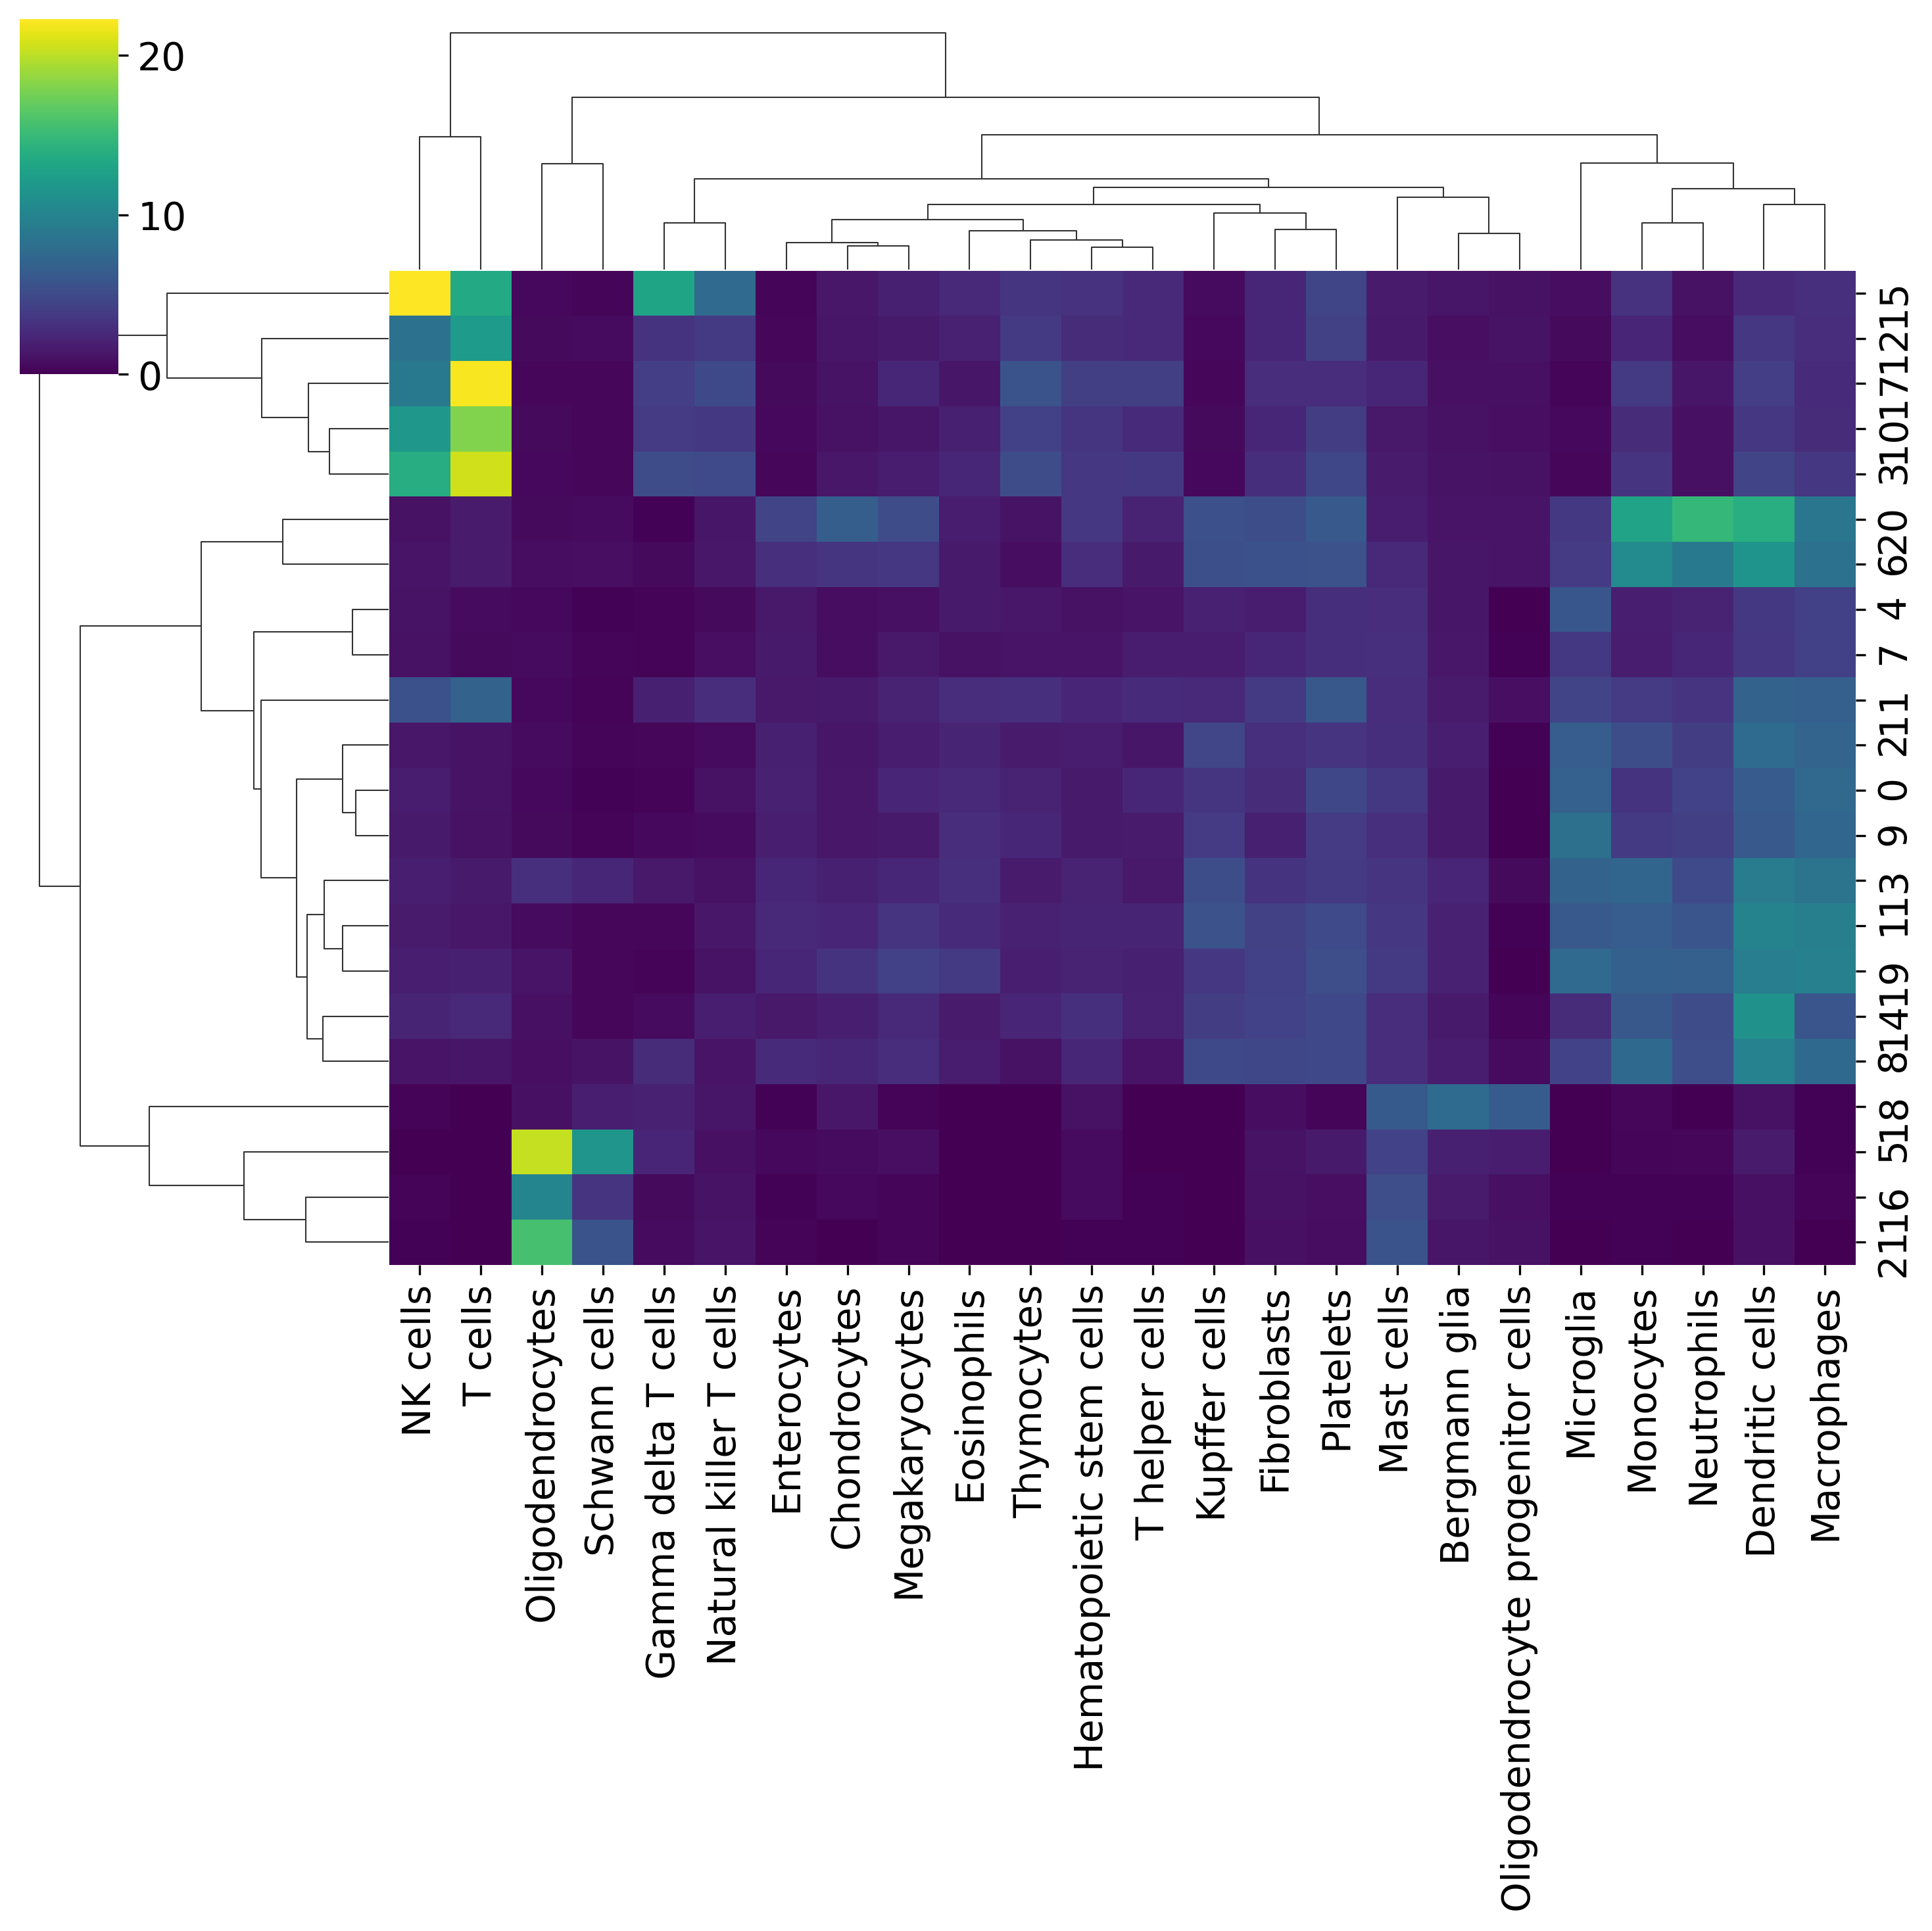

In [63]:
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, cmap='viridis')
plt.show()

In [64]:
annotation_dict = dc.assign_groups(mean_enr)
annotation_dict

{'0': 'Macrophages',
 '1': 'Dendritic cells',
 '10': 'T cells',
 '11': 'Dendritic cells',
 '12': 'T cells',
 '13': 'Dendritic cells',
 '14': 'Dendritic cells',
 '15': 'NK cells',
 '16': 'Oligodendrocytes',
 '17': 'T cells',
 '18': 'Bergmann glia',
 '19': 'Macrophages',
 '2': 'Dendritic cells',
 '20': 'Neutrophils',
 '21': 'Oligodendrocytes',
 '3': 'T cells',
 '4': 'Microglia',
 '5': 'Oligodendrocytes',
 '6': 'Dendritic cells',
 '7': 'Macrophages',
 '8': 'Dendritic cells',
 '9': 'Microglia'}

... storing 'cell_type' as categorical


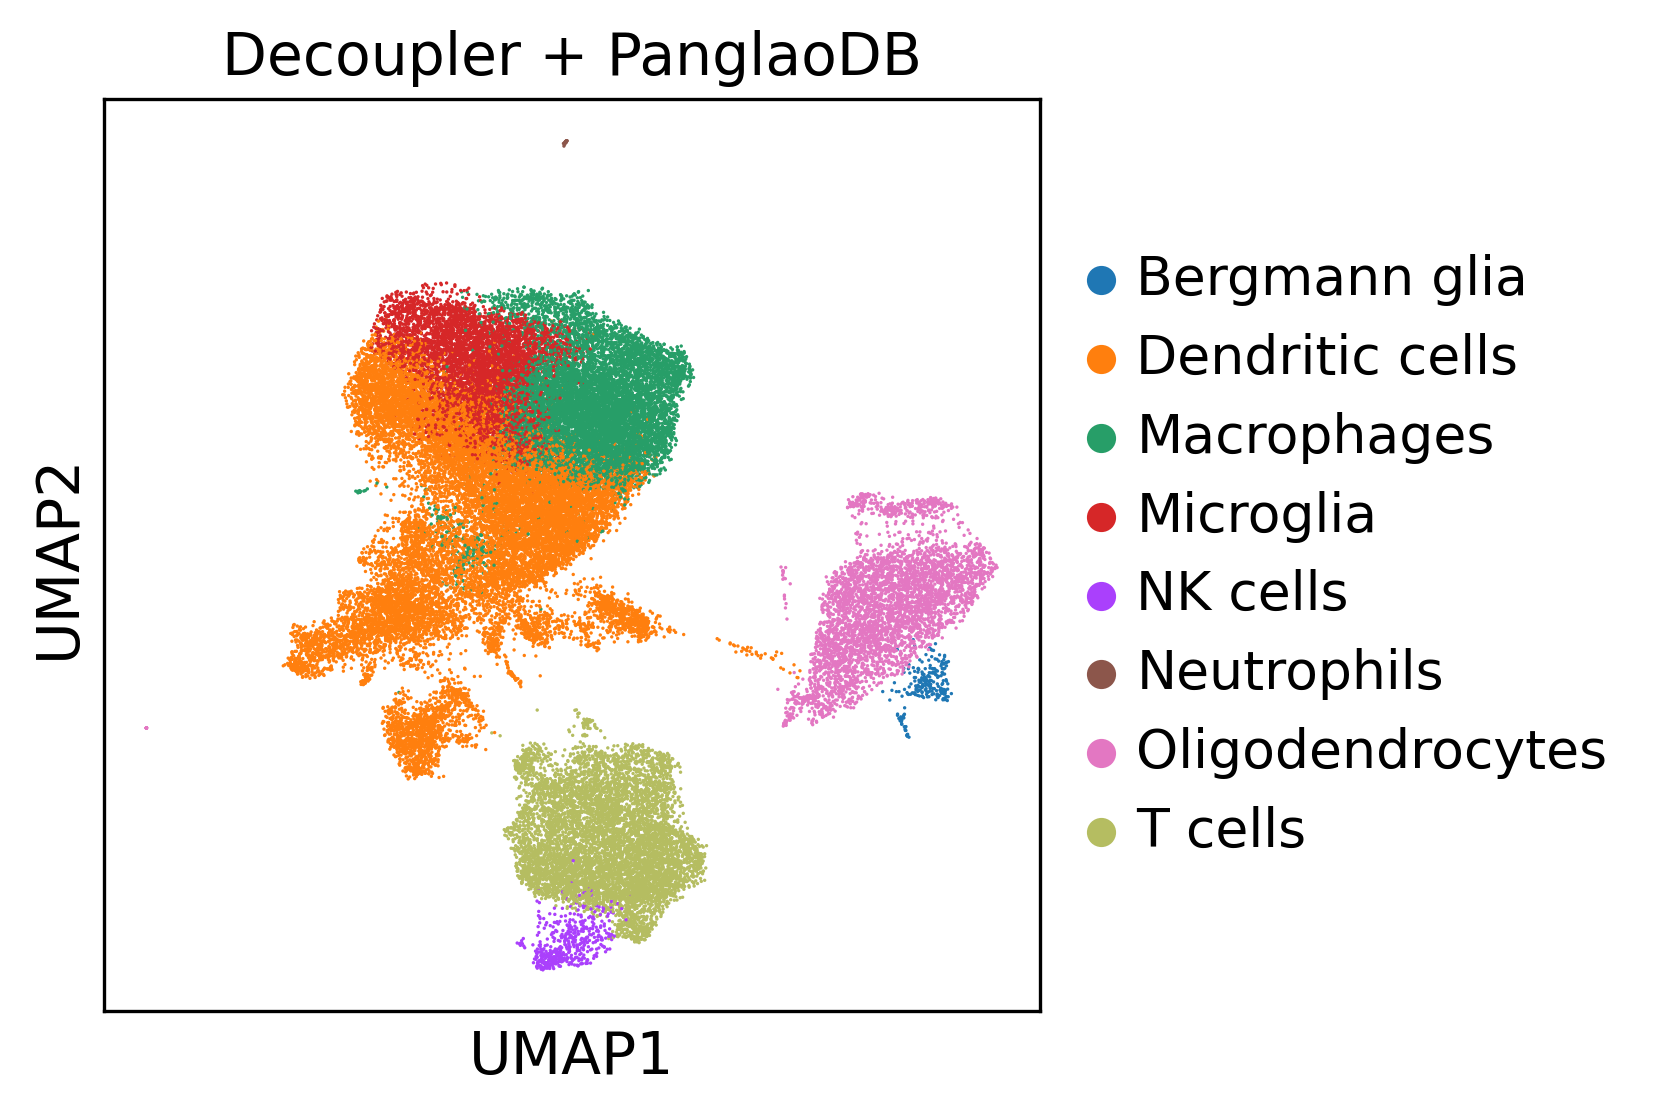

In [65]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type',title='Decoupler + PanglaoDB')

In [66]:
adata

AnnData object with n_obs × n_vars = 45436 × 3669
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X

In [67]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_L_PMID35177622.h5ad")